In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import classification_report

### Data Processing

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

In [3]:
from sklearn import preprocessing

X, Y = train.iloc[:, :-1], train.iloc[:, -1]


In [4]:
df = X
df.select_dtypes(include=['object'])

""
0
1
2
3
4
...
213600
213601
213602
213603


In [5]:
# see if there are missing entries in the dataset features
categorical_columns = df.select_dtypes(include=['object']).columns
print('the number of categorical columns',len(categorical_columns))
print('the number of columns',len(X.columns))
X.isnull().sum().sort_values()

the number of categorical columns 0
the number of columns 31


id        0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V16       0
V15       0
V28       0
V14       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
V1        0
Time      0
V13       0
Amount    0
dtype: int64

In [6]:
null_stat = X.isnull().sum()
null_variables_num = 0
null_categorical_v_n = 0
for i in range(len(X.columns)):
    if null_stat[i]>0:
        null_variables_num+=1
        if X.columns[i] in categorical_columns:
            null_categorical_v_n += 1
            
print('The number of variables containing null value:',null_variables_num)
print('The number of categorical variables containing null value:',null_categorical_v_n)


The number of variables containing null value: 0
The number of categorical variables containing null value: 0


#### encode the categorical variables

In [7]:
X = X.drop(columns=['id'])

In [8]:
test_X = test.drop(columns=['id'])

In [9]:
X['target'] = Y

In [10]:
# Corelation with target
x = X.corr()
pd.DataFrame(x['target']).sort_values(by='target',ascending = False).style.background_gradient(cmap = 'Greens')

,target
target,1
V11,0.153425
V4,0.131623
V2,0.0910271
V21,0.0493181
V19,0.0299777
V27,0.0193756
V20,0.0176278
V8,0.0168258
V28,0.0125597


<function matplotlib.pyplot.show(*args, **kw)>

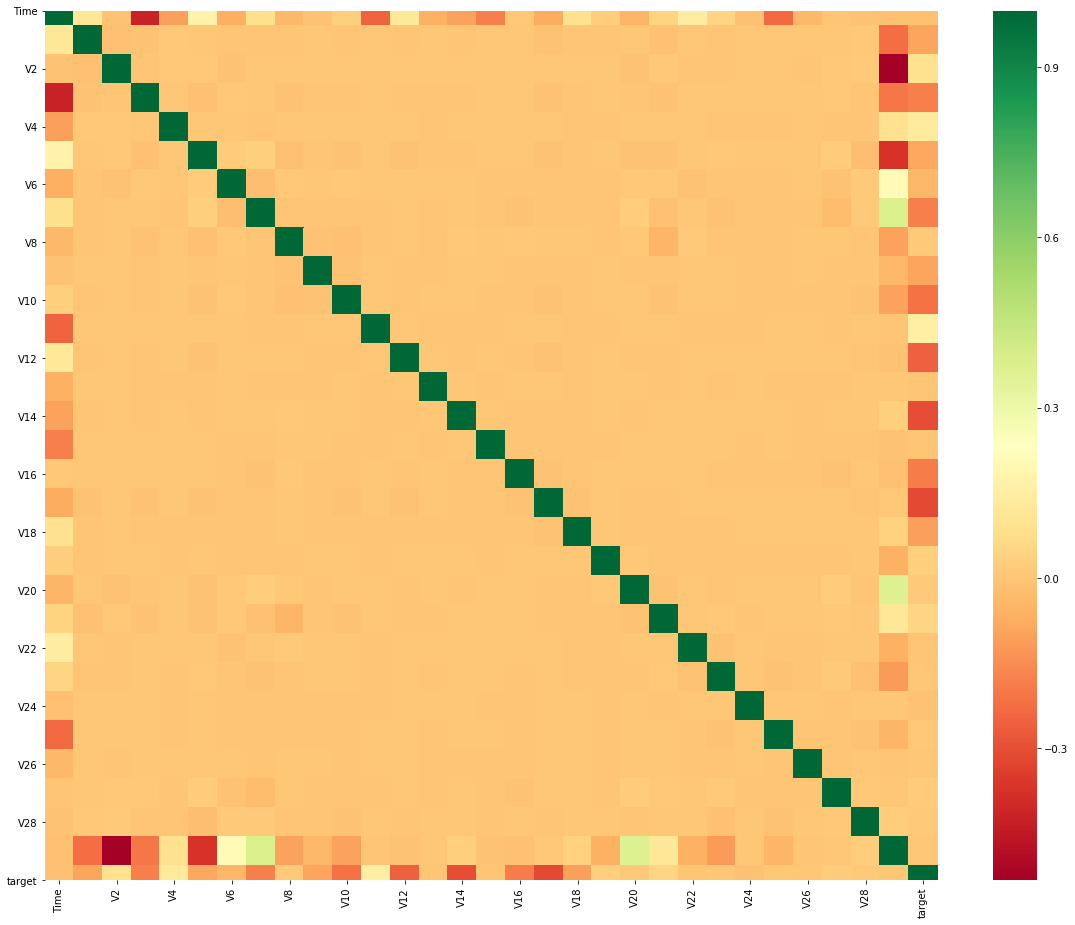

In [11]:
# Correlation tes
sns.heatmap(X.corr(),annot=False,cmap='RdYlGn') 
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.show

In [12]:
neg_num = 0
pos_num = 0
for label in Y:
    if label==0:
        neg_num+=1
    else:
        pos_num+=1
print("the percent of positive data point:%.2f %%" % (pos_num/len(Y)*100))
print("the percent of negative data point:%.2f %%" % (neg_num/len(Y)*100))


the percent of positive data point:0.17 %
the percent of negative data point:99.83 %


In [13]:
train_X = X.drop(columns = ['target'])

## Cross Validation

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

x = pipeline.fit_transform(train_X)
y = Y.to_numpy()


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [16]:
from sklearn.model_selection import KFold
# use logistic regression as baseline
logreg = LogisticRegression()
f1_list = []
auc_list = []
acc_list = []
# prepare cross validation
kf = KFold(n_splits=5, random_state=1, shuffle=True)
#splits a dataset into 5 folds, shuffles prior to the split, set random_state as 1
# enumerate splits
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1_list.append(f1)
    auc_list.append(auc)
    acc_list.append(acc)
    

In [17]:
import statistics 
print("Mean of the f1 score is % s " %(statistics.mean(f1_list))) 
print("Standard Deviation of the f1 score is % s "%(statistics.stdev(f1_list)))
print("Mean of the auc score is % s " %(statistics.mean(auc_list))) 
print("Standard Deviation of the auc score is % s "%(statistics.stdev(auc_list)))
print("Mean of the accuracy score is % s " %(statistics.mean(acc_list))) 
print("Standard Deviation of the accuracy score is % s "%(statistics.stdev(acc_list)))

Mean of the f1 score is 0.7072947515031759 
Standard Deviation of the f1 score is 0.04123003335477149 
Mean of the auc score is 0.8028404068392174 
Standard Deviation of the auc score is 0.01908151407718351 
Mean of the accuracy score is 0.9991432784813089 
Standard Deviation of the accuracy score is 8.536589746872203e-05 


## SMOT

In [18]:
import imblearn
print(imblearn.__version__)

0.8.1


Counter({0: 213236, 1: 369})


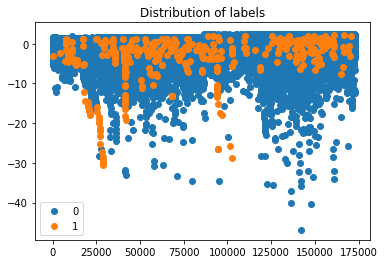

In [19]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
y=Y.to_numpy()
x=train_X.to_numpy()
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(x[row_ix, 0], x[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.title('Distribution of labels')
pyplot.show()


In [59]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
y=Y.to_numpy()
x=train_X.to_numpy()
x, y = pipeline.fit_resample(x, y)

Counter({0: 42646, 1: 21323})


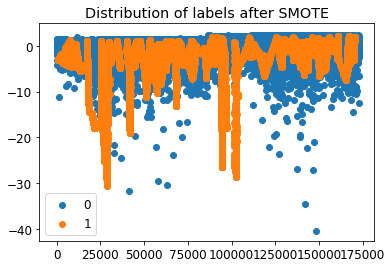

In [60]:
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(x[row_ix, 0], x[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.title('Distribution of labels after SMOTE')
pyplot.show()

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=77)

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [76]:
test_X = pipeline.transform(test_X)

## Cost-Sensitive Learning

'scale_pos_weight' is a  parameter of xgboost which controls the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)

In [36]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 2,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
    'scale_pos_weight':9
}

plst = list(params.items())


dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds)


dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)



[09:20:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:20:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy: 99.95 % 
AUC score 0.904039245765913


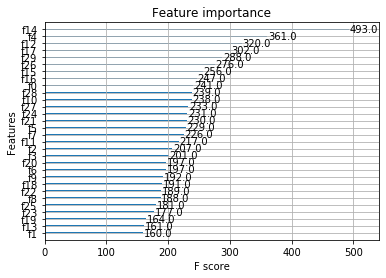

In [37]:
cnt1 = 0
cnt2 = 0
for i in range(len(y_test.to_numpy())):
    if ans[i] == y_test.to_numpy()[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))
print('AUC score',roc_auc_score(y_test.to_numpy(), ans))


plot_importance(model)
plt.show()

In [38]:
dtest = xgb.DMatrix(test_X)
ans = model.predict(dtest)
sample = pd.read_csv('sample_submission.csv')
sample['Class']=[int(label) for label in ans]
sample.to_csv('output2.csv',index=False)
len(sample[sample.Class==1])

114

In [82]:
from sklearn.model_selection import KFold
bst_constr = xgb.XGBClassifier(tree_method="hist",n_estimators=500,scale_pos_weight=9)
f1_list = []
auc_list = []
acc_list = []
roc_cur = []
# prepare cross validation
kf = KFold(n_splits=5, random_state=1, shuffle=True)
#splits a dataset into 5 folds, shuffles prior to the split, set random_state as 1
# enumerate splits
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = bst_constr.fit(X_train, y_train, eval_set=[(X_train, y_train)])
    y_pred_quant = model.predict_proba(X_test)[:, 1]
    y_pred_bin = model.predict(X_test)
    roc_cur.append(roc_curve(y_test, y_pred_quant))
    f1 = f1_score(y_test, y_pred_bin)
    auc = roc_auc_score(y_test, y_pred_bin)
    acc = accuracy_score(y_test, y_pred_bin)
    f1_list.append(f1)
    auc_list.append(auc)
    acc_list.append(acc)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:42:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.43882
[1]	validation_0-logloss:0.29796
[2]	validation_0-logloss:0.20927
[3]	validation_0-logloss:0.14993
[4]	validation_0-logloss:0.10891
[5]	validation_0-logloss:0.07990
[6]	validation_0-logloss:0.05900
[7]	validation_0-logloss:0.04387
[8]	validation_0-logloss:0.03284
[9]	validation_0-logloss:0.02472
[10]	validation_0-logloss:0.01870
[11]	validation_0-logloss:0.01426
[12]	validation_0-logloss:0.01096
[13]	validation_0-logloss:0.00843
[14]	validation_0-logloss:0.00654
[15]	validation_0-logloss:0.00513
[16]	validation_0-logloss:0.00410
[17]	validation_0-logloss:0.00331
[18]	validation_0-logloss:0.00268
[19]	validation_0-logloss:0.00216
[20]	validation_0-logloss:0.00178
[21]	validatio

[230]	validation_0-logloss:0.00002
[231]	validation_0-logloss:0.00002
[232]	validation_0-logloss:0.00002
[233]	validation_0-logloss:0.00002
[234]	validation_0-logloss:0.00002
[235]	validation_0-logloss:0.00002
[236]	validation_0-logloss:0.00002
[237]	validation_0-logloss:0.00002
[238]	validation_0-logloss:0.00002
[239]	validation_0-logloss:0.00002
[240]	validation_0-logloss:0.00002
[241]	validation_0-logloss:0.00002
[242]	validation_0-logloss:0.00002
[243]	validation_0-logloss:0.00002
[244]	validation_0-logloss:0.00002
[245]	validation_0-logloss:0.00002
[246]	validation_0-logloss:0.00002
[247]	validation_0-logloss:0.00002
[248]	validation_0-logloss:0.00002
[249]	validation_0-logloss:0.00002
[250]	validation_0-logloss:0.00002
[251]	validation_0-logloss:0.00002
[252]	validation_0-logloss:0.00002
[253]	validation_0-logloss:0.00002
[254]	validation_0-logloss:0.00002
[255]	validation_0-logloss:0.00002
[256]	validation_0-logloss:0.00002
[257]	validation_0-logloss:0.00002
[258]	validation_0-l

[465]	validation_0-logloss:0.00001
[466]	validation_0-logloss:0.00001
[467]	validation_0-logloss:0.00001
[468]	validation_0-logloss:0.00001
[469]	validation_0-logloss:0.00001
[470]	validation_0-logloss:0.00001
[471]	validation_0-logloss:0.00001
[472]	validation_0-logloss:0.00001
[473]	validation_0-logloss:0.00001
[474]	validation_0-logloss:0.00001
[475]	validation_0-logloss:0.00001
[476]	validation_0-logloss:0.00001
[477]	validation_0-logloss:0.00001
[478]	validation_0-logloss:0.00001
[479]	validation_0-logloss:0.00001
[480]	validation_0-logloss:0.00001
[481]	validation_0-logloss:0.00001
[482]	validation_0-logloss:0.00001
[483]	validation_0-logloss:0.00001
[484]	validation_0-logloss:0.00001
[485]	validation_0-logloss:0.00001
[486]	validation_0-logloss:0.00001
[487]	validation_0-logloss:0.00001
[488]	validation_0-logloss:0.00001
[489]	validation_0-logloss:0.00001
[490]	validation_0-logloss:0.00001
[491]	validation_0-logloss:0.00001
[492]	validation_0-logloss:0.00001
[493]	validation_0-l

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:42:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.43857
[1]	validation_0-logloss:0.29811
[2]	validation_0-logloss:0.20944
[3]	validation_0-logloss:0.15006
[4]	validation_0-logloss:0.10897
[5]	validation_0-logloss:0.07987
[6]	validation_0-logloss:0.05901
[7]	validation_0-logloss:0.04389
[8]	validation_0-logloss:0.03290
[9]	validation_0-logloss:0.02479
[10]	validation_0-logloss:0.01881
[11]	validation_0-logloss:0.01435
[12]	validation_0-logloss:0.01095
[13]	validation_0-logloss:0.00848
[14]	validation_0-logloss:0.00662
[15]	validation_0-logloss:0.00519
[16]	validation_0-logloss:0.00411
[17]	validation_0-logloss:0.00331
[18]	validation_0-logloss:0.00270
[19]	validation_0-logloss:0.00219
[20]	validation_0-logloss:0.00181
[21]	validatio

[230]	validation_0-logloss:0.00002
[231]	validation_0-logloss:0.00002
[232]	validation_0-logloss:0.00002
[233]	validation_0-logloss:0.00002
[234]	validation_0-logloss:0.00002
[235]	validation_0-logloss:0.00002
[236]	validation_0-logloss:0.00002
[237]	validation_0-logloss:0.00002
[238]	validation_0-logloss:0.00002
[239]	validation_0-logloss:0.00002
[240]	validation_0-logloss:0.00002
[241]	validation_0-logloss:0.00002
[242]	validation_0-logloss:0.00002
[243]	validation_0-logloss:0.00002
[244]	validation_0-logloss:0.00002
[245]	validation_0-logloss:0.00002
[246]	validation_0-logloss:0.00002
[247]	validation_0-logloss:0.00002
[248]	validation_0-logloss:0.00002
[249]	validation_0-logloss:0.00002
[250]	validation_0-logloss:0.00002
[251]	validation_0-logloss:0.00002
[252]	validation_0-logloss:0.00002
[253]	validation_0-logloss:0.00002
[254]	validation_0-logloss:0.00002
[255]	validation_0-logloss:0.00002
[256]	validation_0-logloss:0.00002
[257]	validation_0-logloss:0.00002
[258]	validation_0-l

[465]	validation_0-logloss:0.00001
[466]	validation_0-logloss:0.00001
[467]	validation_0-logloss:0.00001
[468]	validation_0-logloss:0.00001
[469]	validation_0-logloss:0.00001
[470]	validation_0-logloss:0.00001
[471]	validation_0-logloss:0.00001
[472]	validation_0-logloss:0.00001
[473]	validation_0-logloss:0.00001
[474]	validation_0-logloss:0.00001
[475]	validation_0-logloss:0.00001
[476]	validation_0-logloss:0.00001
[477]	validation_0-logloss:0.00001
[478]	validation_0-logloss:0.00001
[479]	validation_0-logloss:0.00001
[480]	validation_0-logloss:0.00001
[481]	validation_0-logloss:0.00001
[482]	validation_0-logloss:0.00001
[483]	validation_0-logloss:0.00001
[484]	validation_0-logloss:0.00001
[485]	validation_0-logloss:0.00001
[486]	validation_0-logloss:0.00001
[487]	validation_0-logloss:0.00001
[488]	validation_0-logloss:0.00001
[489]	validation_0-logloss:0.00001
[490]	validation_0-logloss:0.00001
[491]	validation_0-logloss:0.00001
[492]	validation_0-logloss:0.00001
[493]	validation_0-l

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:42:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.43882
[1]	validation_0-logloss:0.29796
[2]	validation_0-logloss:0.20940
[3]	validation_0-logloss:0.15005
[4]	validation_0-logloss:0.10891
[5]	validation_0-logloss:0.07982
[6]	validation_0-logloss:0.05901
[7]	validation_0-logloss:0.04389
[8]	validation_0-logloss:0.03282
[9]	validation_0-logloss:0.02467
[10]	validation_0-logloss:0.01868
[11]	validation_0-logloss:0.01417
[12]	validation_0-logloss:0.01082
[13]	validation_0-logloss:0.00825
[14]	validation_0-logloss:0.00634
[15]	validation_0-logloss:0.00494
[16]	validation_0-logloss:0.00389
[17]	validation_0-logloss:0.00311
[18]	validation_0-logloss:0.00248
[19]	validation_0-logloss:0.00199
[20]	validation_0-logloss:0.00162
[21]	validatio

[230]	validation_0-logloss:0.00002
[231]	validation_0-logloss:0.00002
[232]	validation_0-logloss:0.00002
[233]	validation_0-logloss:0.00002
[234]	validation_0-logloss:0.00002
[235]	validation_0-logloss:0.00002
[236]	validation_0-logloss:0.00002
[237]	validation_0-logloss:0.00002
[238]	validation_0-logloss:0.00002
[239]	validation_0-logloss:0.00002
[240]	validation_0-logloss:0.00002
[241]	validation_0-logloss:0.00002
[242]	validation_0-logloss:0.00002
[243]	validation_0-logloss:0.00002
[244]	validation_0-logloss:0.00002
[245]	validation_0-logloss:0.00002
[246]	validation_0-logloss:0.00002
[247]	validation_0-logloss:0.00002
[248]	validation_0-logloss:0.00002
[249]	validation_0-logloss:0.00002
[250]	validation_0-logloss:0.00002
[251]	validation_0-logloss:0.00002
[252]	validation_0-logloss:0.00002
[253]	validation_0-logloss:0.00002
[254]	validation_0-logloss:0.00002
[255]	validation_0-logloss:0.00002
[256]	validation_0-logloss:0.00002
[257]	validation_0-logloss:0.00002
[258]	validation_0-l

[465]	validation_0-logloss:0.00001
[466]	validation_0-logloss:0.00001
[467]	validation_0-logloss:0.00001
[468]	validation_0-logloss:0.00001
[469]	validation_0-logloss:0.00001
[470]	validation_0-logloss:0.00001
[471]	validation_0-logloss:0.00001
[472]	validation_0-logloss:0.00001
[473]	validation_0-logloss:0.00001
[474]	validation_0-logloss:0.00001
[475]	validation_0-logloss:0.00001
[476]	validation_0-logloss:0.00001
[477]	validation_0-logloss:0.00001
[478]	validation_0-logloss:0.00001
[479]	validation_0-logloss:0.00001
[480]	validation_0-logloss:0.00001
[481]	validation_0-logloss:0.00001
[482]	validation_0-logloss:0.00001
[483]	validation_0-logloss:0.00001
[484]	validation_0-logloss:0.00001
[485]	validation_0-logloss:0.00001
[486]	validation_0-logloss:0.00001
[487]	validation_0-logloss:0.00001
[488]	validation_0-logloss:0.00001
[489]	validation_0-logloss:0.00001
[490]	validation_0-logloss:0.00001
[491]	validation_0-logloss:0.00001
[492]	validation_0-logloss:0.00001
[493]	validation_0-l

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:42:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.43882
[1]	validation_0-logloss:0.29795
[2]	validation_0-logloss:0.20940
[3]	validation_0-logloss:0.15002
[4]	validation_0-logloss:0.10897
[5]	validation_0-logloss:0.07994
[6]	validation_0-logloss:0.05906
[7]	validation_0-logloss:0.04399
[8]	validation_0-logloss:0.03290
[9]	validation_0-logloss:0.02477
[10]	validation_0-logloss:0.01878
[11]	validation_0-logloss:0.01437
[12]	validation_0-logloss:0.01098
[13]	validation_0-logloss:0.00848
[14]	validation_0-logloss:0.00662
[15]	validation_0-logloss:0.00522
[16]	validation_0-logloss:0.00415
[17]	validation_0-logloss:0.00336
[18]	validation_0-logloss:0.00274
[19]	validation_0-logloss:0.00220
[20]	validation_0-logloss:0.00183
[21]	validatio

[230]	validation_0-logloss:0.00002
[231]	validation_0-logloss:0.00002
[232]	validation_0-logloss:0.00002
[233]	validation_0-logloss:0.00002
[234]	validation_0-logloss:0.00002
[235]	validation_0-logloss:0.00002
[236]	validation_0-logloss:0.00002
[237]	validation_0-logloss:0.00002
[238]	validation_0-logloss:0.00002
[239]	validation_0-logloss:0.00002
[240]	validation_0-logloss:0.00002
[241]	validation_0-logloss:0.00002
[242]	validation_0-logloss:0.00002
[243]	validation_0-logloss:0.00002
[244]	validation_0-logloss:0.00002
[245]	validation_0-logloss:0.00002
[246]	validation_0-logloss:0.00002
[247]	validation_0-logloss:0.00002
[248]	validation_0-logloss:0.00002
[249]	validation_0-logloss:0.00002
[250]	validation_0-logloss:0.00002
[251]	validation_0-logloss:0.00002
[252]	validation_0-logloss:0.00002
[253]	validation_0-logloss:0.00002
[254]	validation_0-logloss:0.00002
[255]	validation_0-logloss:0.00002
[256]	validation_0-logloss:0.00002
[257]	validation_0-logloss:0.00002
[258]	validation_0-l

[465]	validation_0-logloss:0.00001
[466]	validation_0-logloss:0.00001
[467]	validation_0-logloss:0.00001
[468]	validation_0-logloss:0.00001
[469]	validation_0-logloss:0.00001
[470]	validation_0-logloss:0.00001
[471]	validation_0-logloss:0.00001
[472]	validation_0-logloss:0.00001
[473]	validation_0-logloss:0.00001
[474]	validation_0-logloss:0.00001
[475]	validation_0-logloss:0.00001
[476]	validation_0-logloss:0.00001
[477]	validation_0-logloss:0.00001
[478]	validation_0-logloss:0.00001
[479]	validation_0-logloss:0.00001
[480]	validation_0-logloss:0.00001
[481]	validation_0-logloss:0.00001
[482]	validation_0-logloss:0.00001
[483]	validation_0-logloss:0.00001
[484]	validation_0-logloss:0.00001
[485]	validation_0-logloss:0.00001
[486]	validation_0-logloss:0.00001
[487]	validation_0-logloss:0.00001
[488]	validation_0-logloss:0.00001
[489]	validation_0-logloss:0.00001
[490]	validation_0-logloss:0.00001
[491]	validation_0-logloss:0.00001
[492]	validation_0-logloss:0.00001
[493]	validation_0-l

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:43:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.43878
[1]	validation_0-logloss:0.29791
[2]	validation_0-logloss:0.20926
[3]	validation_0-logloss:0.14984
[4]	validation_0-logloss:0.10875
[5]	validation_0-logloss:0.07970
[6]	validation_0-logloss:0.05882
[7]	validation_0-logloss:0.04370
[8]	validation_0-logloss:0.03262
[9]	validation_0-logloss:0.02451
[10]	validation_0-logloss:0.01854
[11]	validation_0-logloss:0.01408
[12]	validation_0-logloss:0.01071
[13]	validation_0-logloss:0.00817
[14]	validation_0-logloss:0.00629
[15]	validation_0-logloss:0.00486
[16]	validation_0-logloss:0.00379
[17]	validation_0-logloss:0.00298
[18]	validation_0-logloss:0.00235
[19]	validation_0-logloss:0.00189
[20]	validation_0-logloss:0.00152
[21]	validatio

[230]	validation_0-logloss:0.00002
[231]	validation_0-logloss:0.00002
[232]	validation_0-logloss:0.00002
[233]	validation_0-logloss:0.00002
[234]	validation_0-logloss:0.00002
[235]	validation_0-logloss:0.00002
[236]	validation_0-logloss:0.00002
[237]	validation_0-logloss:0.00002
[238]	validation_0-logloss:0.00002
[239]	validation_0-logloss:0.00002
[240]	validation_0-logloss:0.00002
[241]	validation_0-logloss:0.00002
[242]	validation_0-logloss:0.00002
[243]	validation_0-logloss:0.00002
[244]	validation_0-logloss:0.00002
[245]	validation_0-logloss:0.00002
[246]	validation_0-logloss:0.00002
[247]	validation_0-logloss:0.00002
[248]	validation_0-logloss:0.00002
[249]	validation_0-logloss:0.00002
[250]	validation_0-logloss:0.00002
[251]	validation_0-logloss:0.00002
[252]	validation_0-logloss:0.00002
[253]	validation_0-logloss:0.00002
[254]	validation_0-logloss:0.00002
[255]	validation_0-logloss:0.00002
[256]	validation_0-logloss:0.00002
[257]	validation_0-logloss:0.00002
[258]	validation_0-l

[465]	validation_0-logloss:0.00001
[466]	validation_0-logloss:0.00001
[467]	validation_0-logloss:0.00001
[468]	validation_0-logloss:0.00001
[469]	validation_0-logloss:0.00001
[470]	validation_0-logloss:0.00001
[471]	validation_0-logloss:0.00001
[472]	validation_0-logloss:0.00001
[473]	validation_0-logloss:0.00001
[474]	validation_0-logloss:0.00001
[475]	validation_0-logloss:0.00001
[476]	validation_0-logloss:0.00001
[477]	validation_0-logloss:0.00001
[478]	validation_0-logloss:0.00001
[479]	validation_0-logloss:0.00001
[480]	validation_0-logloss:0.00001
[481]	validation_0-logloss:0.00001
[482]	validation_0-logloss:0.00001
[483]	validation_0-logloss:0.00001
[484]	validation_0-logloss:0.00001
[485]	validation_0-logloss:0.00001
[486]	validation_0-logloss:0.00001
[487]	validation_0-logloss:0.00001
[488]	validation_0-logloss:0.00001
[489]	validation_0-logloss:0.00001
[490]	validation_0-logloss:0.00001
[491]	validation_0-logloss:0.00001
[492]	validation_0-logloss:0.00001
[493]	validation_0-l

In [83]:
print("Mean of the f1 score is % s " %(statistics.mean(f1_list))) 
print("Standard Deviation of the f1 score is % s "%(statistics.stdev(f1_list)))
print("Mean of the auc score is % s " %(statistics.mean(auc_list))) 
print("Standard Deviation of the auc score is % s "%(statistics.stdev(auc_list)))
print("Mean of the accuracy score is % s " %(statistics.mean(acc_list))) 
print("Standard Deviation of the accuracy score is % s "%(statistics.stdev(acc_list)))

Mean of the f1 score is 0.846716533011615 
Standard Deviation of the f1 score is 0.02167105999317582 
Mean of the auc score is 0.8929774865159662 
Standard Deviation of the auc score is 0.009530043203356504 
Mean of the accuracy score is 0.9995131200112357 
Standard Deviation of the accuracy score is 5.337774982325376e-05 


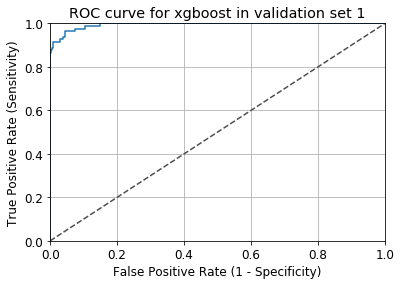

In [86]:
fpr, tpr, thresholds = roc_cur[0]

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for xgboost in validation set 1')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

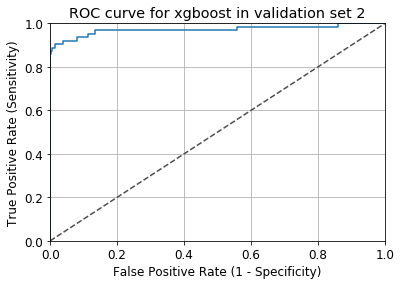

In [87]:
fpr, tpr, thresholds = roc_cur[1]

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for xgboost in validation set 2')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

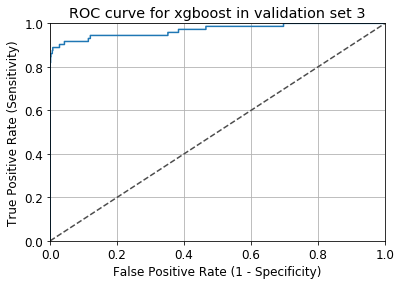

In [88]:
fpr, tpr, thresholds = roc_cur[2]

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for xgboost in validation set 3')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

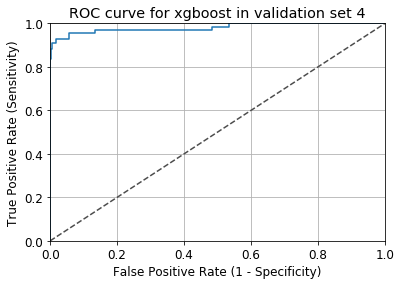

In [89]:
fpr, tpr, thresholds = roc_cur[3]

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for xgboost in validation set 4')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

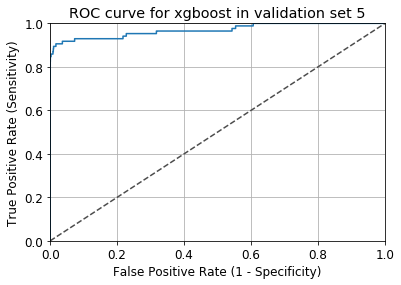

In [90]:
fpr, tpr, thresholds = roc_cur[4]

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for xgboost in validation set 5')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Benchmark model

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, Y, test_size=0.2, random_state=77)


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [18]:
test_X = pipeline.transform(test_X)

### Logistic regression
- logistic regression is a comprehensive model implemented in binary classification

In [106]:
from sklearn.linear_model import LogisticRegression

In [107]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.reshape(-1))
y_pred = logreg.predict(X_test)

In [108]:
print(classification_report(y_test.to_numpy(), y_pred))
print('AUC score',roc_auc_score(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.92      0.63      0.75        73

    accuracy                           1.00     42721
   macro avg       0.96      0.82      0.87     42721
weighted avg       1.00      1.00      1.00     42721

AUC score 0.8150215976338963


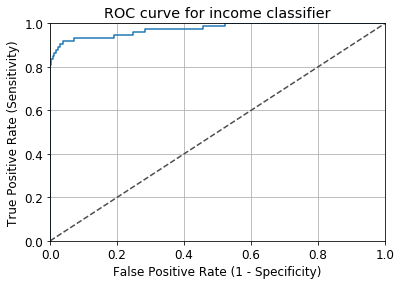

In [109]:
from sklearn.metrics import roc_curve, auc
y_predict = logreg.predict(X_test)
y_pred_quant = logreg.predict_proba(X_test)[:, 1]
y_pred_bin = logreg.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for income classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### SVM

In [26]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train.to_numpy())
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(svm.score(X_test,y_test.to_numpy())*100))
print(classification_report(y_test.to_numpy(), svm.predict(X_test)))

Test Accuracy of SVM Algorithm: 99.93%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.92      0.66      0.77        73

    accuracy                           1.00     42721
   macro avg       0.96      0.83      0.88     42721
weighted avg       1.00      1.00      1.00     42721



In [27]:
print('AUC score',roc_auc_score(y_test.to_numpy(), svm.predict(X_test)))

AUC score 0.8287202277708826


### Naive Bayes 

In [28]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train.to_numpy())
print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(X_test,y_test.to_numpy())*100))
print(classification_report(y_test.to_numpy(), nb.predict(X_test)))

Accuracy of Naive Bayes: 97.77%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42648
           1       0.06      0.82      0.11        73

    accuracy                           0.98     42721
   macro avg       0.53      0.90      0.55     42721
weighted avg       1.00      0.98      0.99     42721



In [29]:
print('AUC score',roc_auc_score(y_test.to_numpy(), nb.predict(X_test)))

AUC score 0.8999384576642692


### Decision Tree 

In [30]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train.to_numpy())
print("Decision Tree Test Accuracy {:.2f}%".format(dtc.score(X_test, y_test.to_numpy())*100))
print(classification_report(y_test.to_numpy(), dtc.predict(X_test)))


Decision Tree Test Accuracy 99.92%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.73      0.79      0.76        73

    accuracy                           1.00     42721
   macro avg       0.87      0.90      0.88     42721
weighted avg       1.00      1.00      1.00     42721



In [31]:
print('AUC score',roc_auc_score(y_test.to_numpy(), dtc.predict(X_test)))

AUC score 0.8970140725094625


### Random Forest

In [39]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 1)
rf.fit(X_train, y_train.to_numpy())
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(rf.score(X_test,y_test.to_numpy())*100))
print(classification_report(y_test.to_numpy(), rf.predict(X_test)))

Random Forest Algorithm Accuracy Score : 99.95%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.92      0.77      0.84        73

    accuracy                           1.00     42721
   macro avg       0.96      0.88      0.92     42721
weighted avg       1.00      1.00      1.00     42721



In [40]:
print('AUC score',roc_auc_score(y_test.to_numpy(), rf.predict(X_test)))

AUC score 0.8835030244396307


### XGBoost

In [33]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 2,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

plst = list(params.items())


dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds)


dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)



[09:15:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:15:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy: 99.95 % 
AUC score 0.904039245765913


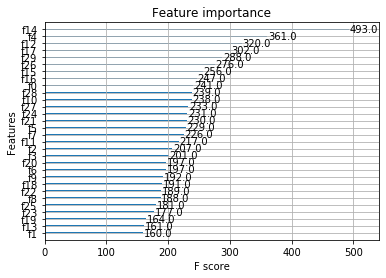

In [34]:
cnt1 = 0
cnt2 = 0
for i in range(len(y_test.to_numpy())):
    if ans[i] == y_test.to_numpy()[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))
print('AUC score',roc_auc_score(y_test.to_numpy(), ans))


plot_importance(model)
plt.show()

In [35]:
dtest = xgb.DMatrix(test_X)
ans = model.predict(dtest)
sample = pd.read_csv('sample_submission.csv')
sample['Class']=[int(label) for label in ans]
sample.to_csv('output2.csv',index=False)
len(sample[sample.Class==1])

114

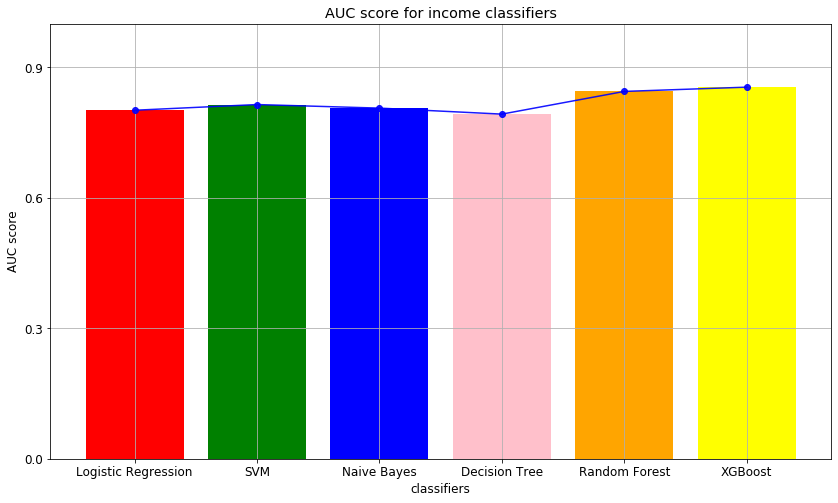

In [203]:
from matplotlib import pyplot as plt
#plt.figure(figsize=(14,7))
methods = ["Logistic Regression", "SVM", "Naive Bayes", "Decision Tree", "Random Forest","XGBoost"]
score = [0.8015, 0.8146, 0.8064, 0.7926, 0.8448, 0.8546]
plt.figure(figsize=(14,8))
plt.plot(range(len(methods)),score, '-o',color='blue',alpha = 0.9)

plt.bar(x=methods, height=score,color=['red','green','b','pink','orange', 'yellow'])
plt.xticks()
plt.ylim((0,1))
plt.yticks(np.arange(0,1.1,0.3))
plt.title('AUC score for income classifiers')
plt.xlabel('classifiers')
plt.ylabel('AUC score')

plt.grid(True)
plt.show()

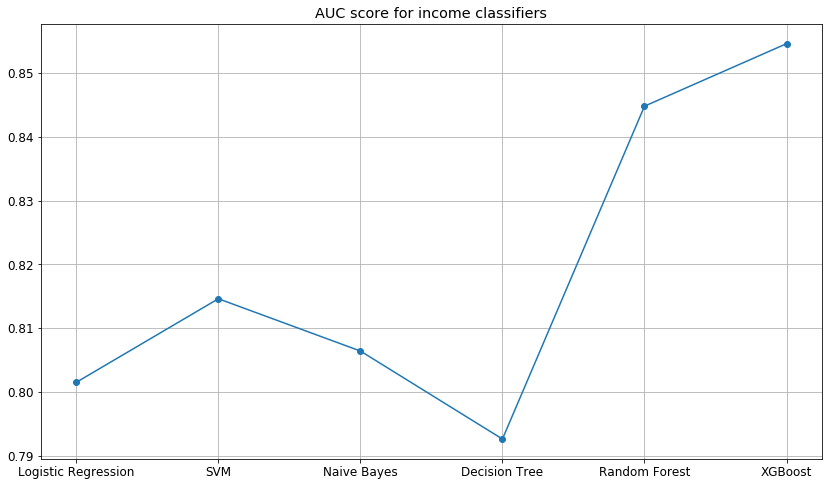

In [205]:
methods = ["Logistic Regression", "SVM", "Naive Bayes", "Decision Tree", "Random Forest","XGBoost"]
score = [0.8015, 0.8146, 0.8064, 0.7926, 0.8448, 0.8546]
plt.figure(figsize=(14,8))
plt.plot(range(len(methods)),score, '-o')

plt.xticks(range(0,6,1),labels = methods)
plt.title('AUC score for income classifiers')
plt.grid(visible=True)

plt.show()

In [206]:
# Predicted values
y_head_lr = logreg.predict(X_test)
y_head_svm = svm.predict(X_test)
y_head_nb = nb.predict(X_test)
y_head_dtc = dtc.predict(X_test)
y_head_rf = rf.predict(X_test)
y_head_xgb = ans

In [207]:
from sklearn.metrics import confusion_matrix
y_test = y_test.to_numpy()
cm_lr = confusion_matrix(y_test,y_head_lr)
cm_svm = confusion_matrix(y_test,y_head_svm)
cm_nb = confusion_matrix(y_test,y_head_nb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rf = confusion_matrix(y_test,y_head_rf)
cm_xgb = confusion_matrix(y_test,y_head_xgb)

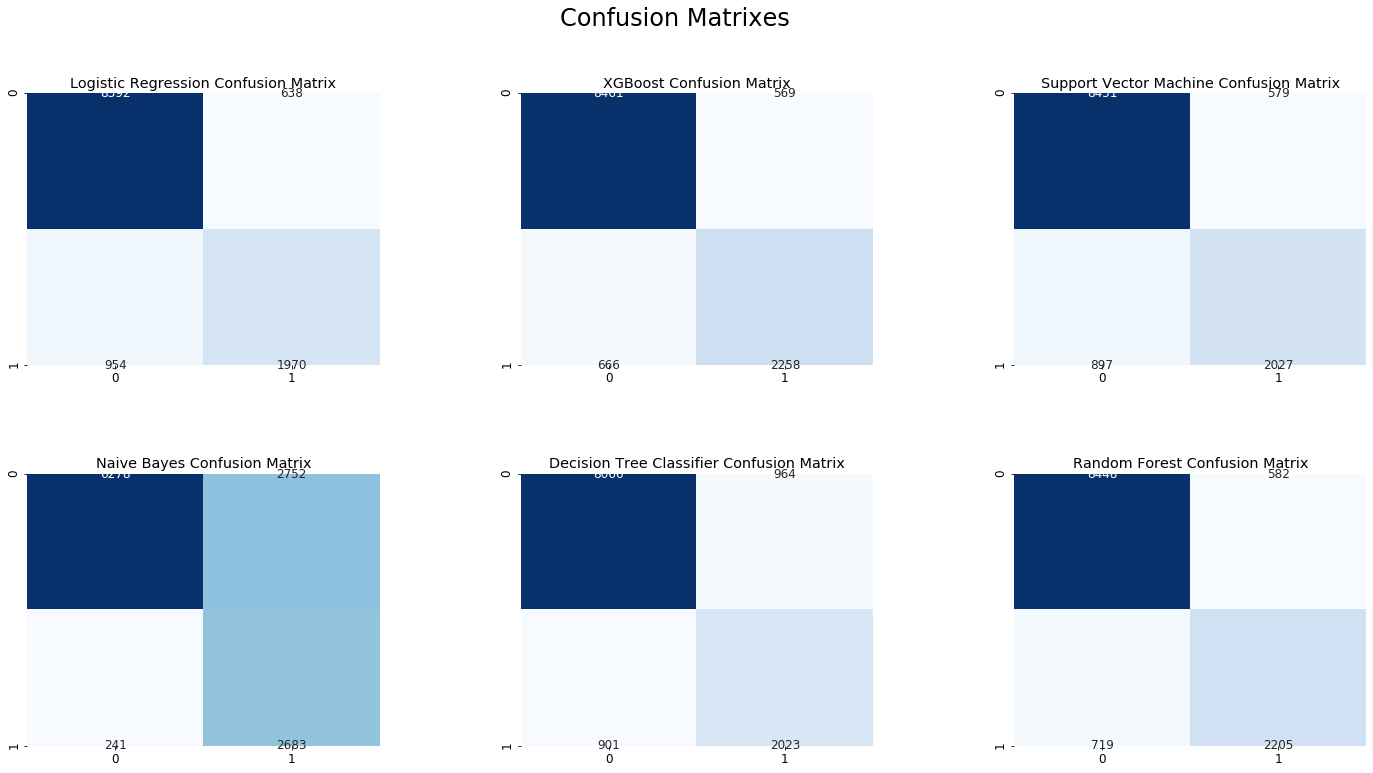

In [208]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,2)
plt.title("XGBoost Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,6)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.show()